In [4]:
%matplotlib inline

In [5]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import shutil

from aptos.data_loader import ImgProcessor

## PreProcess Images

In [7]:
DATA_DIR = Path('../data/raw')
TRAIN_DIR = DATA_DIR / 'train_images'
TEST_DIR  = DATA_DIR / 'test_images'

In [8]:
train_imgs = list(TRAIN_DIR.glob('*.png'))
test_imgs = list(TEST_DIR.glob('*.png'))
print(len(train_imgs), len(test_imgs))

3662 1928


In [5]:
processor = ImgProcessor()

In [11]:
PROCESS_DIR = Path('../data/preprocessed')
PRO_TRAIN_DIR = PROCESS_DIR / 'train_images'
PRO_TEST_DIR = PROCESS_DIR / 'test_images'

PRO_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
PRO_TEST_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
nworkers = 16
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(processor, str(f)): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TRAIN_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 3662/3662 [01:31<00:00, 39.89it/s] 


In [8]:
nworkers = 16
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(processor, str(f)): f for f in test_imgs}
    for future in tqdm(as_completed(results), total=len(test_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TEST_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 1928/1928 [00:20<00:00, 96.18it/s] 


## Copy the labels

In [12]:
train_csv = 'train.csv'
test_csv  = 'test.csv'

In [13]:
shutil.copy(DATA_DIR / train_csv, PROCESS_DIR / train_csv)
shutil.copy(DATA_DIR / test_csv, PROCESS_DIR / test_csv)

PosixPath('../data/preprocessed/test.csv')

## Check train/test examples

In [14]:
pro_train_imgs = list(PRO_TRAIN_DIR.glob('*.npy'))
pro_test_imgs = list(PRO_TEST_DIR.glob('*.npy'))
print(len(pro_train_imgs), len(pro_test_imgs))

3662 1928


In [15]:
n_samples = 10
figsize = 8

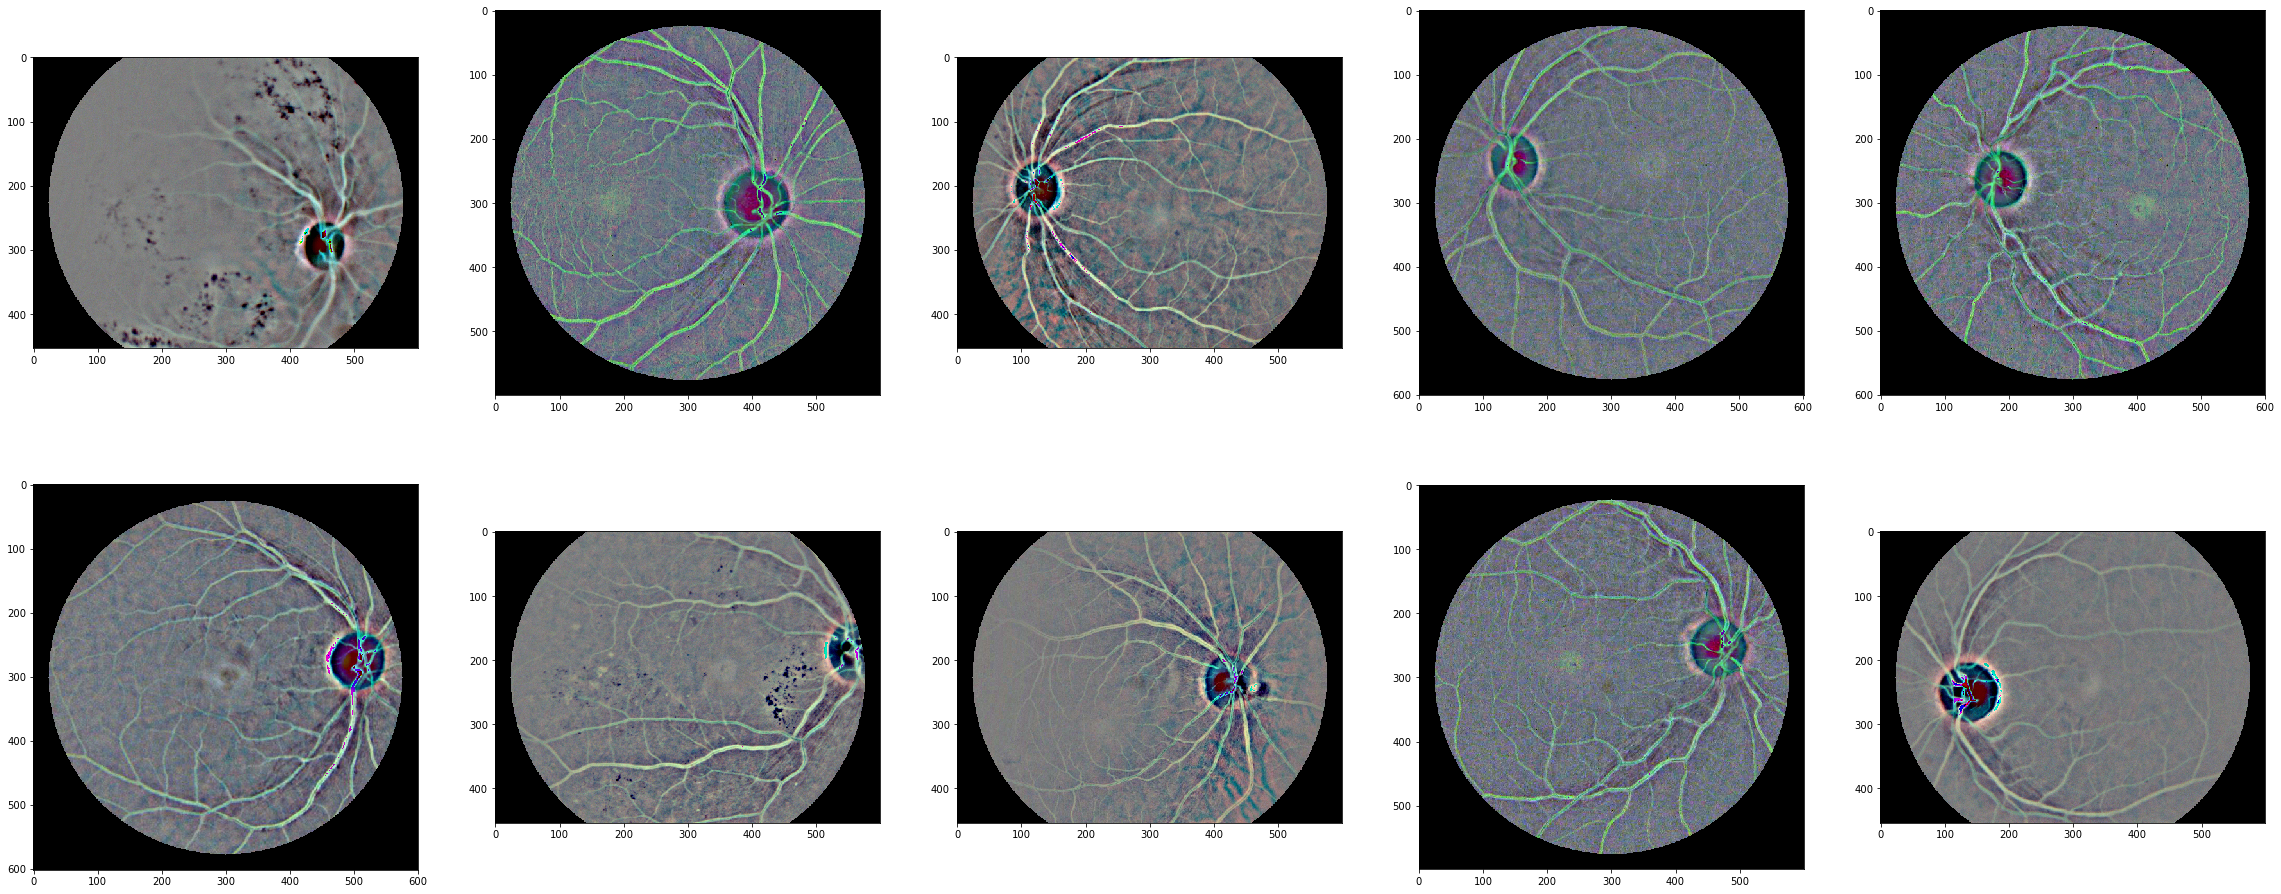

In [17]:
np.random.shuffle(pro_train_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[0, i].imshow(train_img)
for i in range(n_samples // 2, n_samples):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[1, i - n_samples // 2].imshow(train_img)

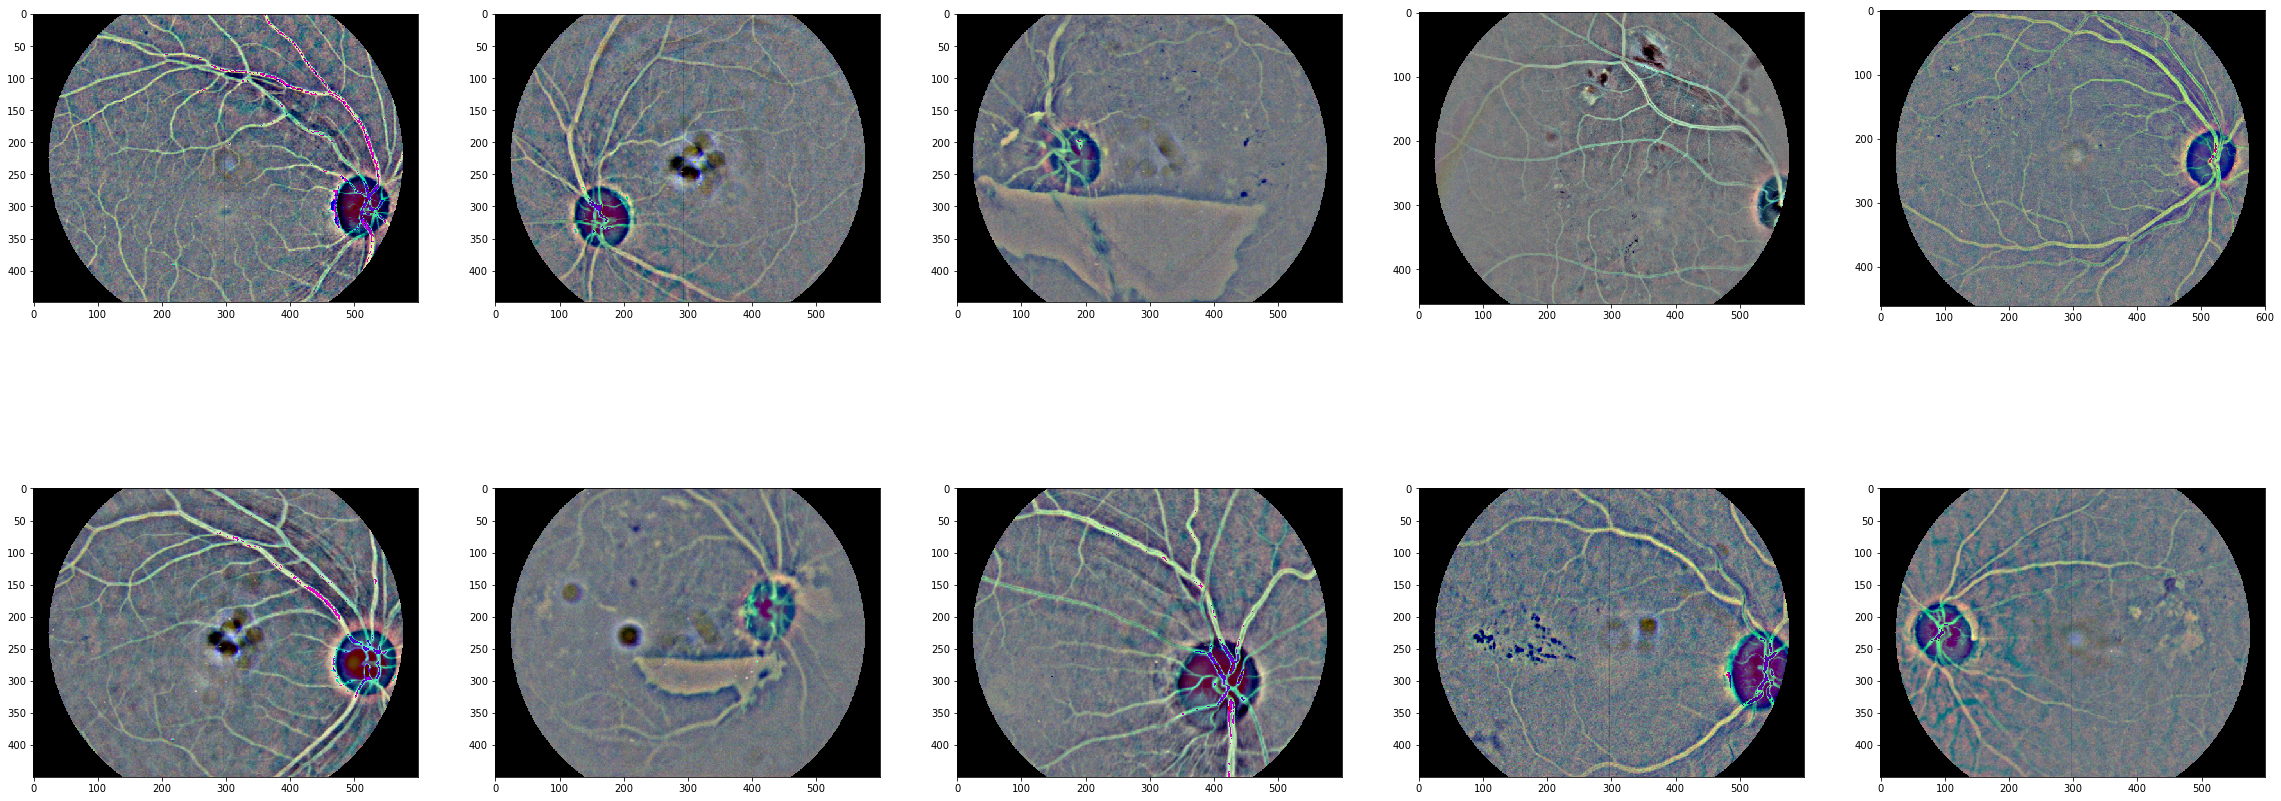

In [18]:
np.random.shuffle(pro_test_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    test_img = np.load(str(pro_test_imgs[i]))
    axs[0, i].imshow(test_img)
for i in range(n_samples // 2, n_samples):
    test_img = np.load(str(pro_test_imgs[i]))
    axs[1, i - n_samples // 2].imshow(test_img)

## Processed image statistics

In [26]:
nworkers = 4
means = np.zeros((len(pro_train_imgs), 3))
variances = np.zeros((len(pro_train_imgs), 3))
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(np.load, str(f)): f for f in pro_train_imgs}
    for future in tqdm(as_completed(results), total=len(pro_train_imgs)):
        img = future.result()
        f = results[future]
        idx = pro_train_imgs.index(f)
        means[idx, 0] = img[:, :, 0].mean()
        means[idx, 1] = img[:, :, 1].mean()
        means[idx, 2] = img[:, :, 2].mean()
        variances[idx, 0] = img[:, :, 0].std() ** 2
        variances[idx, 1] = img[:, :, 1].std() ** 2
        variances[idx, 2] = img[:, :, 2].std() ** 2

100%|██████████| 3662/3662 [00:18<00:00, 199.42it/s]


In [28]:
print(means[:, 0].mean())
print(means[:, 1].mean())
print(means[:, 2].mean())

81.68259022825875
87.81281901701134
92.54638140735202


In [29]:
print(math.sqrt(variances[:, 0].mean()))
print(math.sqrt(variances[:, 1].mean()))
print(math.sqrt(variances[:, 2].mean()))

51.061115180201085
54.74800421817656
55.74811655328235
